In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from collections import Counter

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [47]:
# Set the current working directory
%cd "/home/jayvaidya/Documents/MSDS498"

/home/jayvaidya/Documents/MSDS498


In [3]:
# Set device growth to TRUE to enable GPU utilization
for device in tensorflow.config.experimental.list_physical_devices('GPU'):
    tensorflow.config.experimental.set_memory_growth(device, True)

In [18]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [13]:
# Define the function used to build the encoder for the transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [14]:
# Define a function that will build the model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [53]:
# Setup a model checkpoint callback that can be used to save trained models
checkpoint_path = "nn_model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [60]:
def model_checkpoint_cb(filename='nn_model_checkpoints/cp.ckpt'):
    
    checkpoint_path = filename
    checkpoint_dir = os.path.dirname(checkpoint_path)

    model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor='sparse_categorical_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback

In [10]:
# Read in the train and test data for the SPY lag data
X_train_nn = pd.read_pickle('X_train_nn')
y_train_nn = pd.read_pickle('y_train_nn')
X_test_nn = pd.read_pickle('X_test_nn')
y_test_nn = pd.read_pickle('y_test_nn')

X_train_nn_v2 = pd.read_pickle('X_train_nn_v2')
y_train_nn_v2 = pd.read_pickle('y_train_nn_v2')
X_test_nn_v2 = pd.read_pickle('X_test_nn_v2')
y_test_nn_v2 = pd.read_pickle('y_test_nn_v2')

In [11]:
# Send the data to np arrays
X_train_nn = X_train_nn.to_numpy()
X_test_nn = X_test_nn.to_numpy()

X_train_nn_v2 = X_train_nn_v2.to_numpy()
X_test_nn_v2 = X_test_nn_v2.to_numpy()

# Reshape the datasets to the requirements of the transformer-based Keras architecture
X_train_nn = X_train_nn.reshape((X_train_nn.shape[0], X_train_nn.shape[1], 1))
X_test_nn = X_test_nn.reshape((X_test_nn.shape[0], X_test_nn.shape[1], 1))

X_train_nn_v2 = X_train_nn_v2.reshape((X_train_nn_v2.shape[0], X_train_nn_v2.shape[1], 1))
X_test_nn_v2 = X_test_nn_v2.reshape((X_test_nn_v2.shape[0], X_test_nn_v2.shape[1], 1))

In [7]:
# set a variable containing the number of classes used for predictions
n_classes = len(np.unique(y_train_nn))

In [12]:
# Randomly permutate the data (i.e. shuffle)
idx = np.random.permutation(len(X_train_nn))
X_train_nn = X_train_nn[idx]
y_train_nn = y_train_nn[idx]

idx = np.random.permutation(len(X_train_nn_v2))
X_train_nn_v2 = X_train_nn_v2[idx]
y_train_nn_v2 = y_train_nn_v2[idx]

In [83]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_nn.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_nn,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_nn, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 6, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp.ckpt/assets


6/6 [==============================] - 2s 204ms/step - loss: 0.6898 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.6872 - val_sparse_categorical_accuracy: 0.6364
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.6871 - val_sparse_categorical_accuracy: 0.6364
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.6870 - val_sparse_categorical_accuracy: 0.6364
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6896 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.6869 - val_sparse_categorical_accuracy: 0.6364
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6880 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.6868 - val_sparse_categorical_accuracy: 0.6364
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6869 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.

[0.688587486743927, 0.625]

In [84]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_nn)
preds = np.argmax(preds, axis=1)

Test Set Prediction Accuracy: 0.625
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


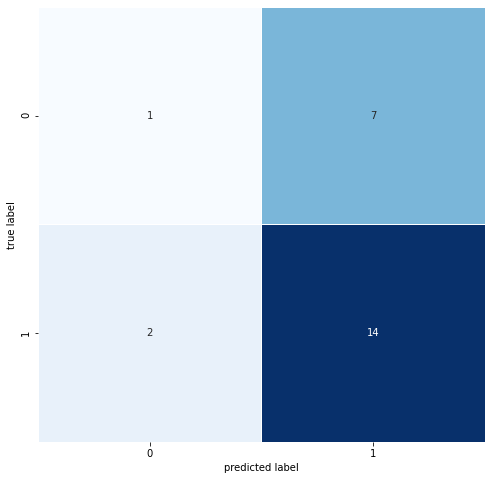

In [85]:
# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

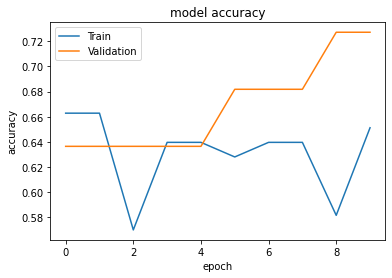

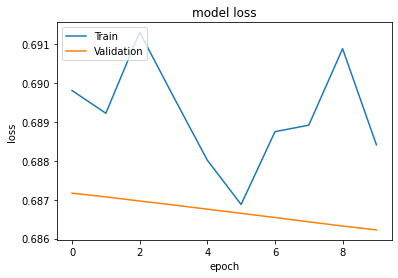

In [86]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [105]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_nn_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_nn_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_nn_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_nn_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 6, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


5/5 [==============================] - 2s 256ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6896 - sparse_categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.6907 - sparse_categorical_accuracy: 0.6184 - val_loss: 0.6975 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6910 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


5/5 [==============================] - 1s 232ms/step - loss: 0.6893 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.6971 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6879 - sparse_categorical_accuracy: 0.7500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


5/5 [==============================] - 1s 301ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.6579 - val_loss: 0.6968 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6875 - sparse_categorical_accuracy: 0.6053 - val_loss: 0.6964 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6835 - sparse_categorical_accuracy: 0.7500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.6875 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.6961 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6863 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.6957 - val_sparse_categorical_accuracy: 0.5000
Epoch 8/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6792 - sparse_categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_nn_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.6954 - val_sparse_categorical_accuracy: 0.5500
Epoch 9/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.6951 - val_sparse_categorical_accuracy: 0.5500
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.6111


[0.6858804225921631, 0.6111111044883728]

Test Set Prediction Accuracy: 0.6111
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


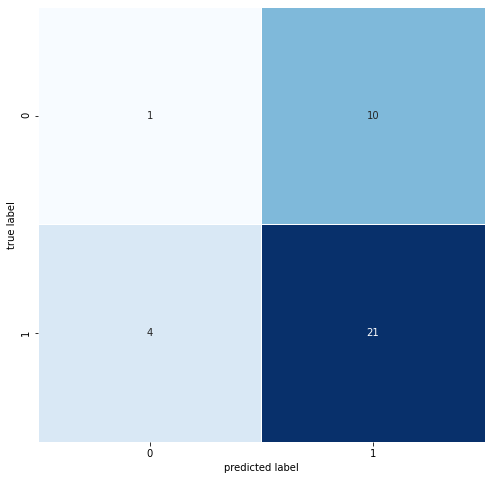

In [106]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_nn_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

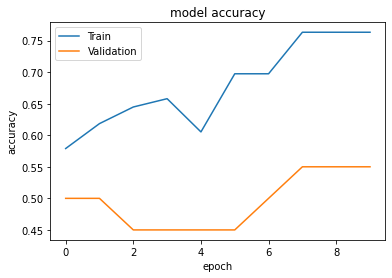

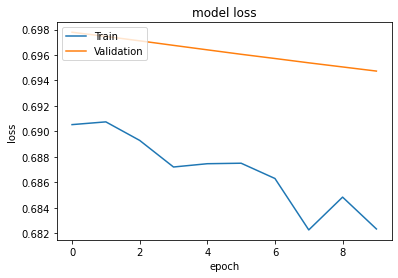

In [107]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [108]:
# Read in the train data for all of the 'thresh 5' datasets
X_train_thresh_5_full = pd.read_pickle('X_train_thresh_5_full')
X_train_thresh_5_full_v2 = pd.read_pickle('X_train_thresh_5_full_v2')
X_test_thresh_5_full = pd.read_pickle('X_test_thresh_5_full')
X_test_thresh_5_full_v2 = pd.read_pickle('X_test_thresh_5_full_v2')

X_train_thresh_5 = pd.read_pickle('X_train_thresh_5')
X_train_thresh_5_v2 = pd.read_pickle('X_train_thresh_5_v2')
X_test_thresh_5 = pd.read_pickle('X_test_thresh_5')
X_test_thresh_5_v2 = pd.read_pickle('X_test_thresh_5_v2')

X_train_thresh_5_clstr = pd.read_pickle('X_train_thresh_5_clstr')
X_train_thresh_5_clstr_v2 = pd.read_pickle('X_train_thresh_5_clstr_v2')
X_test_thresh_5_clstr = pd.read_pickle('X_test_thresh_5_clstr')
X_test_thresh_5_clstr_v2 = pd.read_pickle('X_test_thresh_5_clstr_v2')

In [109]:
# Send the data to np arrays
X_train_thresh_5_full = X_train_thresh_5_full.to_numpy()
X_test_thresh_5_full = X_test_thresh_5_full.to_numpy()
X_train_thresh_5_full_v2 = X_train_thresh_5_full_v2.to_numpy()
X_test_thresh_5_full_v2 = X_test_thresh_5_full_v2.to_numpy()

X_train_thresh_5 = X_train_thresh_5.to_numpy()
X_test_thresh_5 = X_test_thresh_5.to_numpy()
X_train_thresh_5_v2 = X_train_thresh_5_v2.to_numpy()
X_test_thresh_5_v2 = X_test_thresh_5_v2.to_numpy()

X_train_thresh_5_clstr = X_train_thresh_5_clstr.to_numpy()
X_test_thresh_5_clstr = X_test_thresh_5_clstr.to_numpy()
X_train_thresh_5_clstr_v2 = X_train_thresh_5_clstr_v2.to_numpy()
X_test_thresh_5_clstr_v2 = X_test_thresh_5_clstr_v2.to_numpy()

# Reshape the datasets to the requirements of the transformer-based Keras architecture
X_train_thresh_5_full = X_train_thresh_5_full.reshape((X_train_thresh_5_full.shape[0], X_train_thresh_5_full.shape[1], 1))
X_test_thresh_5_full = X_test_thresh_5_full.reshape((X_test_thresh_5_full.shape[0], X_test_thresh_5_full.shape[1], 1))
X_train_thresh_5_full_v2 = X_train_thresh_5_full_v2.reshape((X_train_thresh_5_full_v2.shape[0], X_train_thresh_5_full_v2.shape[1], 1))
X_test_thresh_5_full_v2 = X_test_thresh_5_full_v2.reshape((X_test_thresh_5_full_v2.shape[0], X_test_thresh_5_full_v2.shape[1], 1))

X_train_thresh_5 = X_train_thresh_5.reshape((X_train_thresh_5.shape[0], X_train_thresh_5.shape[1], 1))
X_test_thresh_5 = X_test_thresh_5.reshape((X_test_thresh_5.shape[0], X_test_thresh_5.shape[1], 1))
X_train_thresh_5_v2 = X_train_thresh_5_v2.reshape((X_train_thresh_5_v2.shape[0], X_train_thresh_5_v2.shape[1], 1))
X_test_thresh_5_v2 = X_test_thresh_5_v2.reshape((X_test_thresh_5_v2.shape[0], X_test_thresh_5_v2.shape[1], 1))

X_train_thresh_5_clstr = X_train_thresh_5_clstr.reshape((X_train_thresh_5_clstr.shape[0], X_train_thresh_5_clstr.shape[1], 1))
X_test_thresh_5_clstr = X_test_thresh_5_clstr.reshape((X_test_thresh_5_clstr.shape[0], X_test_thresh_5_clstr.shape[1], 1))
X_train_thresh_5_clstr_v2 = X_train_thresh_5_clstr_v2.reshape((X_train_thresh_5_clstr_v2.shape[0], X_train_thresh_5_clstr_v2.shape[1], 1))
X_test_thresh_5_clstr_v2 = X_test_thresh_5_clstr_v2.reshape((X_test_thresh_5_clstr_v2.shape[0], X_test_thresh_5_clstr_v2.shape[1], 1))

In [116]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_thresh_5_full.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_thresh_5_full.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_thresh_5_full,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_thresh_5_full, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full.ckpt/assets


6/6 [==============================] - 2s 207ms/step - loss: 0.7312 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.7314 - val_sparse_categorical_accuracy: 0.3636
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 0.7664 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.7156 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7510 - sparse_categorical_accuracy: 0.5349 - val_loss: 0.7000 - val_sparse_categorical_accuracy: 0.5455
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7660 - sparse_categorical_accuracy: 0.4884 - val_loss: 0.6862 - val_sparse_categorical_accuracy: 0.6364
Epoch 5/10
1/6 [====>.........................] - ETA: 0s - loss: 0.5681 - sparse_categorical_accuracy: 0.8125INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full.ckpt/assets


6/6 [==============================] - 1s 251ms/step - loss: 0.6427 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7325 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.6818
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7935 - sparse_categorical_accuracy: 0.4767 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.7273
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 0.7260 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.6441 - val_sparse_categorical_accuracy: 0.6364
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.6380 - val_sparse_categorical_accuracy: 0.6818
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.5000


[0.6699283123016357, 0.5]

Test Set Prediction Accuracy: 0.5
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


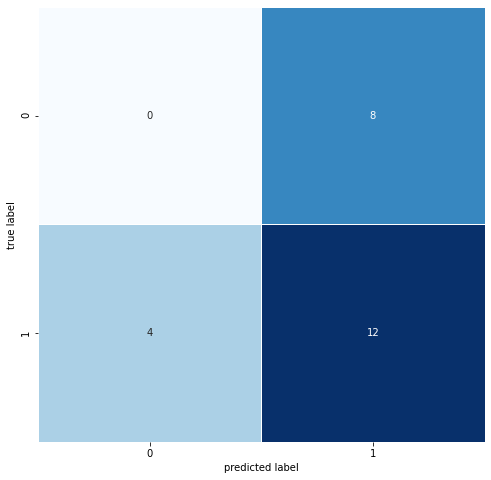

In [117]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_thresh_5_full)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

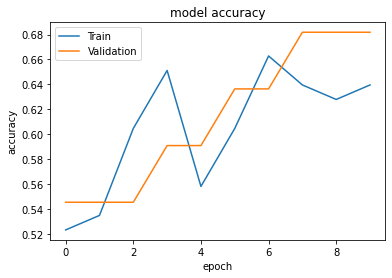

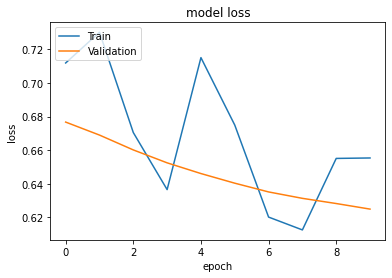

In [112]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [121]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_thresh_5_full_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_thresh_5_full_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_thresh_5_full_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_thresh_5_full_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


5/5 [==============================] - 2s 340ms/step - loss: 0.8791 - sparse_categorical_accuracy: 0.4605 - val_loss: 0.7982 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 0.9918 - sparse_categorical_accuracy: 0.3553 - val_loss: 0.7821 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/10
5/5 [==============================] - 0s 11ms/step - loss: 0.9095 - sparse_categorical_accuracy: 0.4605 - val_loss: 0.7676 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/10
5/5 [==============================] - 0s 10ms/step - loss: 0.9125 - sparse_categorical_accuracy: 0.3816 - val_loss: 0.7542 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
1/5 [=====>........................] - ETA: 0s - loss: 0.8492 - sparse_categorical_accuracy: 0.3750INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.7675 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7411 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6578 - sparse_categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


5/5 [==============================] - 1s 237ms/step - loss: 0.7894 - sparse_categorical_accuracy: 0.5526 - val_loss: 0.7296 - val_sparse_categorical_accuracy: 0.3500
Epoch 7/10
5/5 [==============================] - 0s 11ms/step - loss: 0.8457 - sparse_categorical_accuracy: 0.4868 - val_loss: 0.7195 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7982 - sparse_categorical_accuracy: 0.5132 - val_loss: 0.7101 - val_sparse_categorical_accuracy: 0.5500
Epoch 9/10
5/5 [==============================] - 0s 11ms/step - loss: 0.7884 - sparse_categorical_accuracy: 0.4605 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.5000
Epoch 10/10
1/5 [=====>........................] - ETA: 0s - loss: 0.8982 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_full_v2.ckpt/assets


2/2 [==============================] - 0s 2ms/step - loss: 0.6908 - sparse_categorical_accuracy: 0.5556


[0.6907998919487, 0.5555555820465088]

Test Set Prediction Accuracy: 0.5556
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


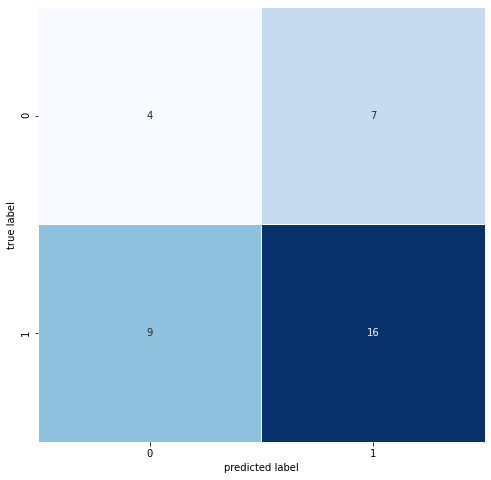

In [122]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_thresh_5_full_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

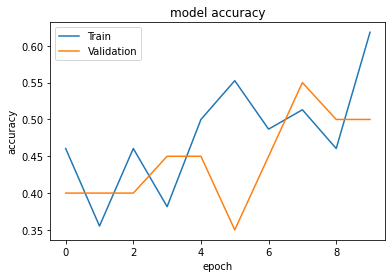

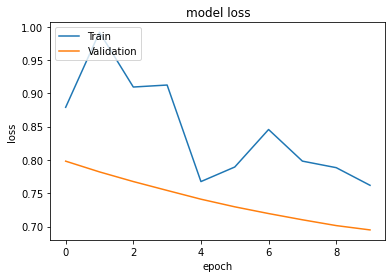

In [123]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [128]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_thresh_5.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_thresh_5.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_thresh_5,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_thresh_5, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 4, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 4, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


6/6 [==============================] - 2s 207ms/step - loss: 0.7255 - sparse_categorical_accuracy: 0.4767 - val_loss: 0.6589 - val_sparse_categorical_accuracy: 0.4545
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7518 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


6/6 [==============================] - 1s 259ms/step - loss: 0.7055 - sparse_categorical_accuracy: 0.4884 - val_loss: 0.6555 - val_sparse_categorical_accuracy: 0.5909
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7378 - sparse_categorical_accuracy: 0.4651 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.5909
Epoch 4/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7150 - sparse_categorical_accuracy: 0.3750INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


6/6 [==============================] - 1s 191ms/step - loss: 0.6852 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.6493 - val_sparse_categorical_accuracy: 0.6818
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7539 - sparse_categorical_accuracy: 0.3837 - val_loss: 0.6462 - val_sparse_categorical_accuracy: 0.6818
Epoch 6/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6756 - sparse_categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5.ckpt/assets


6/6 [==============================] - 1s 189ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.6432 - val_sparse_categorical_accuracy: 0.6818
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6795 - sparse_categorical_accuracy: 0.6047 - val_loss: 0.6406 - val_sparse_categorical_accuracy: 0.6818
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6982 - sparse_categorical_accuracy: 0.5349 - val_loss: 0.6380 - val_sparse_categorical_accuracy: 0.7273
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6688 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.7273
Epoch 10/10
1/1 [==============================] - 0s 16ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.7500


[0.6330175995826721, 0.75]

Test Set Prediction Accuracy: 0.75
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


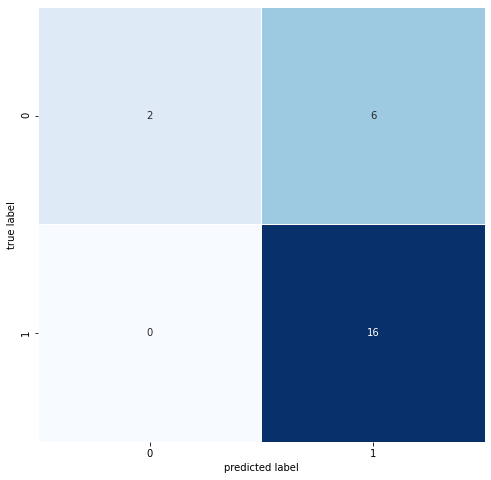

In [129]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_thresh_5)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

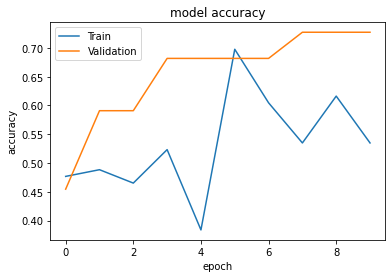

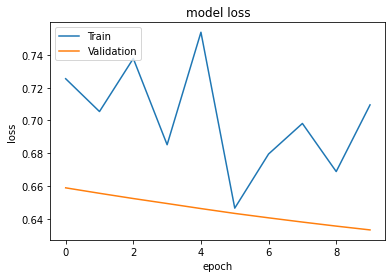

In [130]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [131]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_thresh_5_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_thresh_5_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_thresh_5_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_thresh_5_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 4, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 4, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_v2.ckpt/assets


5/5 [==============================] - 2s 349ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6120 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6239 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.5136 - sparse_categorical_accuracy: 0.8125INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_v2.ckpt/assets


2/2 [==============================] - 0s 3ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.6944


[0.6485171914100647, 0.6944444179534912]

Test Set Prediction Accuracy: 0.6944
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


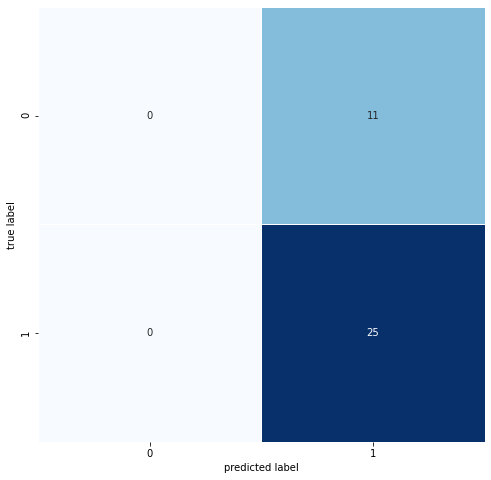

In [134]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_thresh_5_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

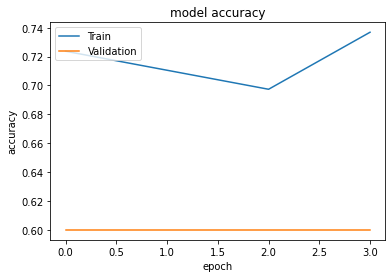

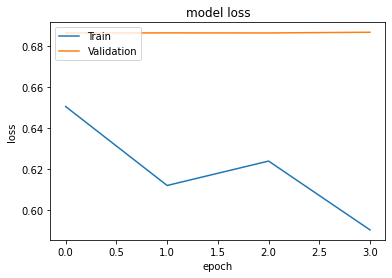

In [133]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [136]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_thresh_5_clstr.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_thresh_5_clstr.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_thresh_5_clstr,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_thresh_5_clstr, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 17, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 17, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 17, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr.ckpt/assets


6/6 [==============================] - 2s 210ms/step - loss: 0.6999 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.6367 - val_sparse_categorical_accuracy: 0.7273
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6402 - sparse_categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr.ckpt/assets


6/6 [==============================] - 1s 189ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.6342 - val_sparse_categorical_accuracy: 0.7273
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.6314 - val_sparse_categorical_accuracy: 0.7273
Epoch 4/10
1/6 [====>.........................] - ETA: 0s - loss: 0.5014 - sparse_categorical_accuracy: 0.8125INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr.ckpt/assets


6/6 [==============================] - 1s 190ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.6294 - val_sparse_categorical_accuracy: 0.6818
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.6280 - val_sparse_categorical_accuracy: 0.6818
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6996 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6267 - val_sparse_categorical_accuracy: 0.6818
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7579 - sparse_categorical_accuracy: 0.6047 - val_loss: 0.6250 - val_sparse_categorical_accuracy: 0.6818
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 0.7765 - sparse_categorical_accuracy: 0.5465 - val_loss: 0.6237 - val_sparse_categorical_accuracy: 0.6818
Epoch 9/10
6/6 [==============================] - 0s 8ms/step - loss: 0.7547 - sparse_categorical_accuracy: 0.5930 - val_loss: 0.

[0.6871524453163147, 0.6666666865348816]

Test Set Prediction Accuracy: 0.6667
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


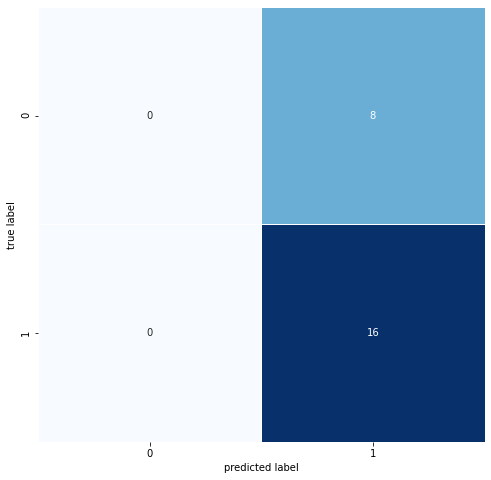

In [137]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_thresh_5_clstr)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

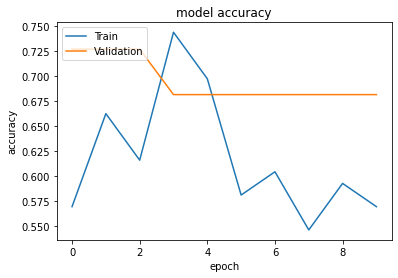

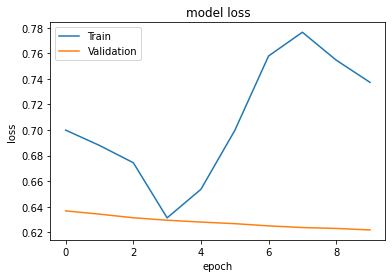

In [138]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [148]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_thresh_5_clstr_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_thresh_5_clstr_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_thresh_5_clstr_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 17, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 17, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 17, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


5/5 [==============================] - 2s 339ms/step - loss: 0.9370 - sparse_categorical_accuracy: 0.3421 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7046 - sparse_categorical_accuracy: 0.4375INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 232ms/step - loss: 0.8354 - sparse_categorical_accuracy: 0.3684 - val_loss: 0.7491 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.8825 - sparse_categorical_accuracy: 0.3553 - val_loss: 0.7395 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7912 - sparse_categorical_accuracy: 0.4375INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 236ms/step - loss: 0.8220 - sparse_categorical_accuracy: 0.3947 - val_loss: 0.7307 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7282 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 240ms/step - loss: 0.8891 - sparse_categorical_accuracy: 0.4342 - val_loss: 0.7225 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7541 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_thresh_5_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 315ms/step - loss: 0.7771 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/10
5/5 [==============================] - 0s 11ms/step - loss: 0.8658 - sparse_categorical_accuracy: 0.3289 - val_loss: 0.7077 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/10
5/5 [==============================] - 0s 11ms/step - loss: 0.7440 - sparse_categorical_accuracy: 0.4737 - val_loss: 0.7017 - val_sparse_categorical_accuracy: 0.5000
Epoch 9/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7612 - sparse_categorical_accuracy: 0.4342 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.5500
Epoch 10/10
2/2 [==============================] - 0s 3ms/step - loss: 0.6728 - sparse_categorical_accuracy: 0.5556


[0.6728311777114868, 0.5555555820465088]

Test Set Prediction Accuracy: 0.5556
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


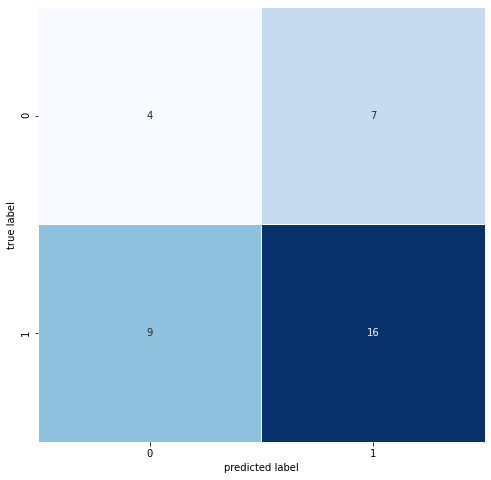

In [149]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_thresh_5_clstr_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

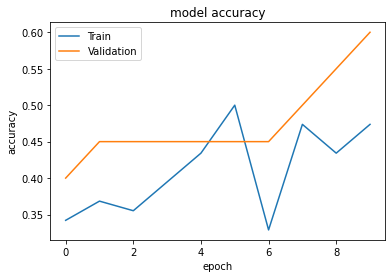

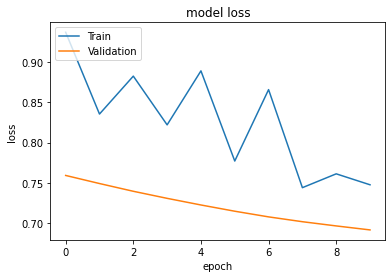

In [150]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [143]:
# Read in the train data for all of the 'thresh 5' datasets
X_train_pct_25_full = pd.read_pickle('X_train_pct_25_full')
X_train_pct_25_full_v2 = pd.read_pickle('X_train_pct_25_full_v2')
X_test_pct_25_full = pd.read_pickle('X_test_pct_25_full')
X_test_pct_25_full_v2 = pd.read_pickle('X_test_pct_25_full_v2')

X_train_pct_25 = pd.read_pickle('X_train_pct_25')
X_train_pct_25_v2 = pd.read_pickle('X_train_pct_25_v2')
X_test_pct_25 = pd.read_pickle('X_test_pct_25')
X_test_pct_25_v2 = pd.read_pickle('X_test_pct_25_v2')

X_train_pct_25_clstr = pd.read_pickle('X_train_pct_25_clstr')
X_train_pct_25_clstr_v2 = pd.read_pickle('X_train_pct_25_clstr_v2')
X_test_pct_25_clstr = pd.read_pickle('X_test_pct_25_clstr')
X_test_pct_25_clstr_v2 = pd.read_pickle('X_test_pct_25_clstr_v2')

In [144]:
# Send the data to np arrays
X_train_pct_25_full = X_train_pct_25_full.to_numpy()
X_test_pct_25_full = X_test_pct_25_full.to_numpy()
X_train_pct_25_full_v2 = X_train_pct_25_full_v2.to_numpy()
X_test_pct_25_full_v2 = X_test_pct_25_full_v2.to_numpy()

X_train_pct_25 = X_train_pct_25.to_numpy()
X_test_pct_25 = X_test_pct_25.to_numpy()
X_train_pct_25_v2 = X_train_pct_25_v2.to_numpy()
X_test_pct_25_v2 = X_test_pct_25_v2.to_numpy()

X_train_pct_25_clstr = X_train_pct_25_clstr.to_numpy()
X_test_pct_25_clstr = X_test_pct_25_clstr.to_numpy()
X_train_pct_25_clstr_v2 = X_train_pct_25_clstr_v2.to_numpy()
X_test_pct_25_clstr_v2 = X_test_pct_25_clstr_v2.to_numpy()

# Reshape the datasets to the requirements of the transformer-based Keras architecture
X_train_pct_25_full = X_train_pct_25_full.reshape((X_train_pct_25_full.shape[0], X_train_pct_25_full.shape[1], 1))
X_test_pct_25_full = X_test_pct_25_full.reshape((X_test_pct_25_full.shape[0], X_test_pct_25_full.shape[1], 1))
X_train_pct_25_full_v2 = X_train_pct_25_full_v2.reshape((X_train_pct_25_full_v2.shape[0], X_train_pct_25_full_v2.shape[1], 1))
X_test_pct_25_full_v2 = X_test_pct_25_full_v2.reshape((X_test_pct_25_full_v2.shape[0], X_test_pct_25_full_v2.shape[1], 1))

X_train_pct_25 = X_train_pct_25.reshape((X_train_pct_25.shape[0], X_train_pct_25.shape[1], 1))
X_test_pct_25 = X_test_pct_25.reshape((X_test_pct_25.shape[0], X_test_pct_25.shape[1], 1))
X_train_pct_25_v2 = X_train_pct_25_v2.reshape((X_train_pct_25_v2.shape[0], X_train_pct_25_v2.shape[1], 1))
X_test_pct_25_v2 = X_test_pct_25_v2.reshape((X_test_pct_25_v2.shape[0], X_test_pct_25_v2.shape[1], 1))

X_train_pct_25_clstr = X_train_pct_25_clstr.reshape((X_train_pct_25_clstr.shape[0], X_train_pct_25_clstr.shape[1], 1))
X_test_pct_25_clstr = X_test_pct_25_clstr.reshape((X_test_pct_25_clstr.shape[0], X_test_pct_25_clstr.shape[1], 1))
X_train_pct_25_clstr_v2 = X_train_pct_25_clstr_v2.reshape((X_train_pct_25_clstr_v2.shape[0], X_train_pct_25_clstr_v2.shape[1], 1))
X_test_pct_25_clstr_v2 = X_test_pct_25_clstr_v2.reshape((X_test_pct_25_clstr_v2.shape[0], X_test_pct_25_clstr_v2.shape[1], 1))

In [151]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_25.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_25.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_25,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_25, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 7, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 7, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 7, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


6/6 [==============================] - 2s 216ms/step - loss: 1.0591 - sparse_categorical_accuracy: 0.2791 - val_loss: 0.9427 - val_sparse_categorical_accuracy: 0.3182
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 1.0332 - sparse_categorical_accuracy: 0.2500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


6/6 [==============================] - 1s 190ms/step - loss: 1.0448 - sparse_categorical_accuracy: 0.2907 - val_loss: 0.9328 - val_sparse_categorical_accuracy: 0.3182
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 1.0170 - sparse_categorical_accuracy: 0.2907 - val_loss: 0.9235 - val_sparse_categorical_accuracy: 0.3182
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.9814 - sparse_categorical_accuracy: 0.2674 - val_loss: 0.9145 - val_sparse_categorical_accuracy: 0.3182
Epoch 5/10
1/6 [====>.........................] - ETA: 0s - loss: 1.0716 - sparse_categorical_accuracy: 0.3125INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


6/6 [==============================] - 1s 190ms/step - loss: 0.9454 - sparse_categorical_accuracy: 0.3023 - val_loss: 0.9058 - val_sparse_categorical_accuracy: 0.3182
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.9564 - sparse_categorical_accuracy: 0.2791 - val_loss: 0.8973 - val_sparse_categorical_accuracy: 0.3182
Epoch 7/10
1/6 [====>.........................] - ETA: 0s - loss: 1.0873 - sparse_categorical_accuracy: 0.1250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25.ckpt/assets


6/6 [==============================] - 1s 257ms/step - loss: 0.9716 - sparse_categorical_accuracy: 0.3256 - val_loss: 0.8890 - val_sparse_categorical_accuracy: 0.3182
Epoch 8/10
6/6 [==============================] - 0s 8ms/step - loss: 1.0432 - sparse_categorical_accuracy: 0.2791 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.3182
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 0.9070 - sparse_categorical_accuracy: 0.3140 - val_loss: 0.8725 - val_sparse_categorical_accuracy: 0.3182
Epoch 10/10
1/1 [==============================] - 0s 28ms/step - loss: 0.9030 - sparse_categorical_accuracy: 0.3333


[0.9030012488365173, 0.3333333432674408]

Test Set Prediction Accuracy: 0.3333
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


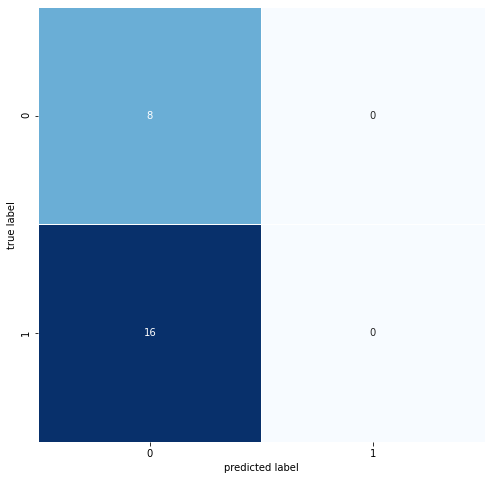

In [152]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_25)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

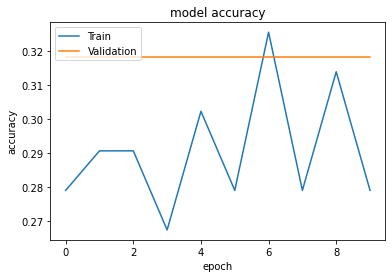

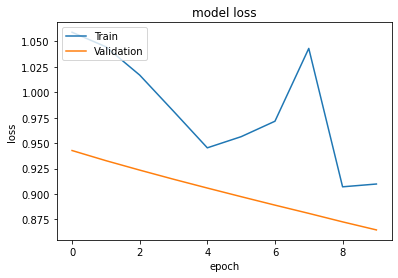

In [153]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [155]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_25_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_25_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_25_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_25_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 7, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 7, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 7, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_v2.ckpt/assets


5/5 [==============================] - 2s 340ms/step - loss: 0.7044 - sparse_categorical_accuracy: 0.5132 - val_loss: 0.7094 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7659 - sparse_categorical_accuracy: 0.4375INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_v2.ckpt/assets


5/5 [==============================] - 1s 234ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.7088 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.6053 - val_loss: 0.7082 - val_sparse_categorical_accuracy: 0.4500
Epoch 4/10
5/5 [==============================] - 0s 11ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.6184 - val_loss: 0.7077 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.5132 - val_loss: 0.7071 - val_sparse_categorical_accuracy: 0.4500
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.6184 - val_loss: 0.7065 - val_sparse_categorical_accuracy: 0.4500
Epoch 7/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6347 - sparse_categorical_accuracy: 0.7500INFO:tensorflow

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_v2.ckpt/assets


5/5 [==============================] - 1s 234ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6579 - val_loss: 0.7061 - val_sparse_categorical_accuracy: 0.4500
Epoch 8/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6847 - sparse_categorical_accuracy: 0.5395 - val_loss: 0.7055 - val_sparse_categorical_accuracy: 0.4500
Epoch 9/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.7050 - val_sparse_categorical_accuracy: 0.5000
Epoch 10/10
2/2 [==============================] - 0s 2ms/step - loss: 0.6558 - sparse_categorical_accuracy: 0.6389


[0.6557652950286865, 0.6388888955116272]

Test Set Prediction Accuracy: 0.6389
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


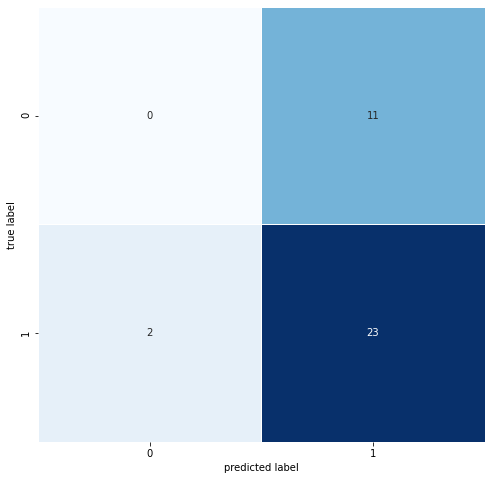

In [156]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_25_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

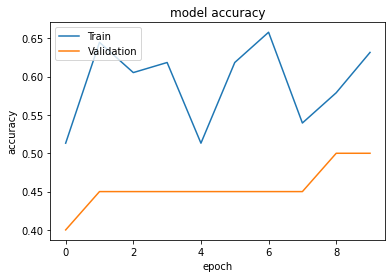

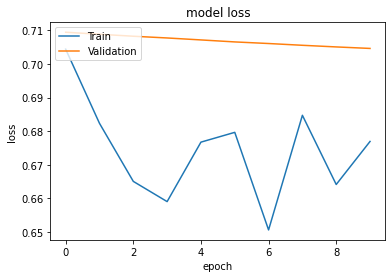

In [157]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [158]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_25_full.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_25_full.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_25_full,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_25_full, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


6/6 [==============================] - 2s 266ms/step - loss: 1.0007 - sparse_categorical_accuracy: 0.3256 - val_loss: 0.7857 - val_sparse_categorical_accuracy: 0.4545
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 0.9229 - sparse_categorical_accuracy: 0.3256 - val_loss: 0.7719 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10
1/6 [====>.........................] - ETA: 0s - loss: 0.9568 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


6/6 [==============================] - 1s 191ms/step - loss: 0.9267 - sparse_categorical_accuracy: 0.3837 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.9118 - sparse_categorical_accuracy: 0.3605 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10
1/6 [====>.........................] - ETA: 0s - loss: 1.0570 - sparse_categorical_accuracy: 0.2500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


6/6 [==============================] - 1s 190ms/step - loss: 0.8747 - sparse_categorical_accuracy: 0.4651 - val_loss: 0.7355 - val_sparse_categorical_accuracy: 0.4545
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.8674 - sparse_categorical_accuracy: 0.3837 - val_loss: 0.7254 - val_sparse_categorical_accuracy: 0.5455
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.8760 - sparse_categorical_accuracy: 0.4651 - val_loss: 0.7151 - val_sparse_categorical_accuracy: 0.5455
Epoch 8/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7295 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full.ckpt/assets


6/6 [==============================] - 1s 189ms/step - loss: 0.7608 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.7049 - val_sparse_categorical_accuracy: 0.5455
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 0.8432 - sparse_categorical_accuracy: 0.3953 - val_loss: 0.6959 - val_sparse_categorical_accuracy: 0.5455
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.6250


[0.6310393214225769, 0.625]

Test Set Prediction Accuracy: 0.625
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


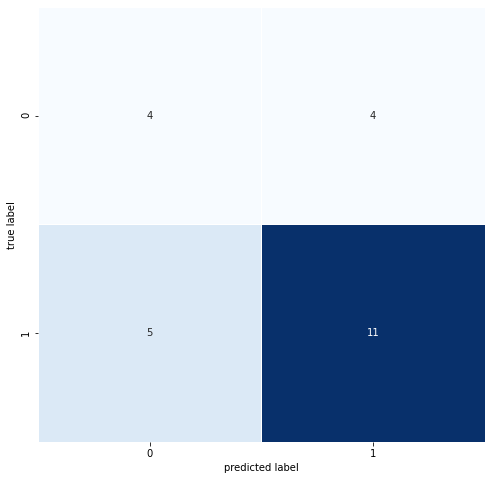

In [159]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_25_full)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

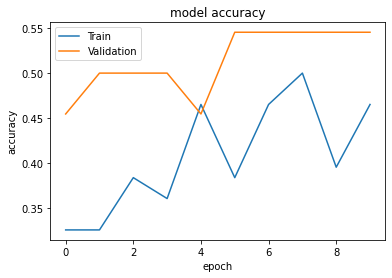

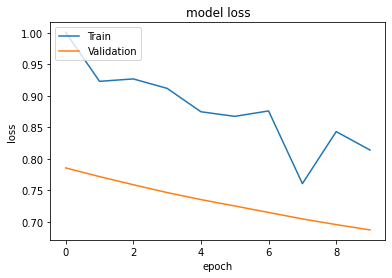

In [160]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [166]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_25_full_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_25_full_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_25_full_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_25_full_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_v2.ckpt/assets


5/5 [==============================] - 2s 259ms/step - loss: 0.8216 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.8062 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.8896 - sparse_categorical_accuracy: 0.4737 - val_loss: 0.7969 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.8162 - sparse_categorical_accuracy: 0.4737 - val_loss: 0.7887 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7199 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.7699 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.7805 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 0.8156 - sparse_categorical_accuracy: 0.4868 - val_loss: 0.7732 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 0.8609 - sparse_categorical_accuracy: 0.4868 - val_loss: 0.7665 - val_sparse_categorical_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7457 - sparse_categorical_accuracy: 0.5658 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.5000
Epoch 8/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7235 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.7557 - val_sparse_categorical_accuracy: 0.5500
Epoch 9/10
5/5 [==============================] - 0s 9ms/step - loss: 0.7764 - sparse_categorical_accuracy: 0.5526 - val_loss

[0.6910245418548584, 0.5277777910232544]

Test Set Prediction Accuracy: 0.5278
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


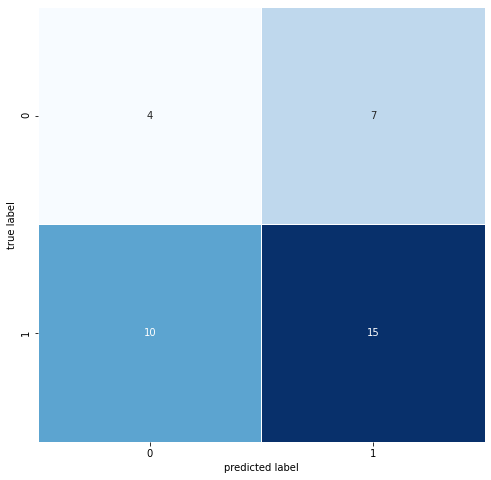

In [167]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_25_full_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

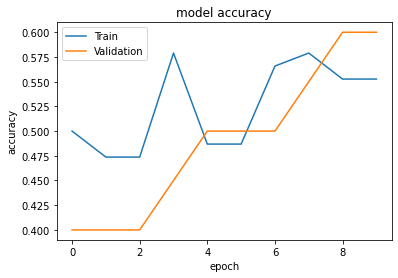

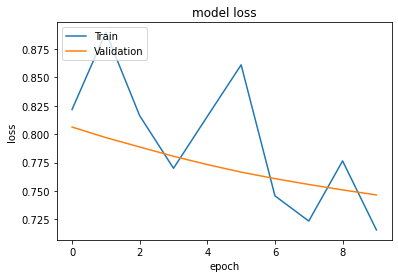

In [168]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [169]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_25_clstr.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_25_full_clstr.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_25_clstr,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_25_clstr, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 13, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 13, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 13, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_clstr.ckpt/assets


6/6 [==============================] - 2s 214ms/step - loss: 0.6952 - sparse_categorical_accuracy: 0.5930 - val_loss: 0.6514 - val_sparse_categorical_accuracy: 0.6364
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7248 - sparse_categorical_accuracy: 0.4375INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_clstr.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_clstr.ckpt/assets


6/6 [==============================] - 1s 188ms/step - loss: 0.6400 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.6364
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6798 - sparse_categorical_accuracy: 0.6047 - val_loss: 0.6471 - val_sparse_categorical_accuracy: 0.6818
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6746 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.6818
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7494 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.6429 - val_sparse_categorical_accuracy: 0.6818
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.6414 - val_sparse_categorical_accuracy: 0.6818
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7326 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.

[0.7306950688362122, 0.5833333134651184]

Test Set Prediction Accuracy: 0.5833
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


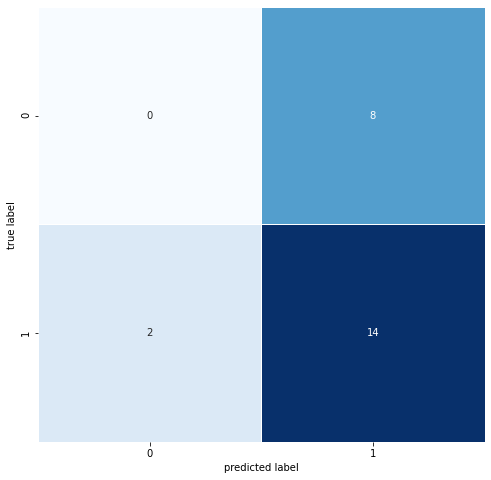

In [170]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_25_clstr)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

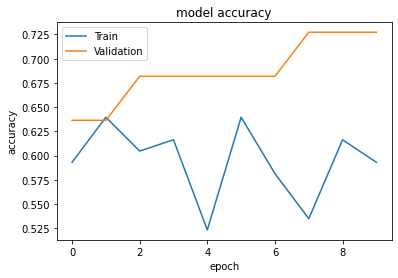

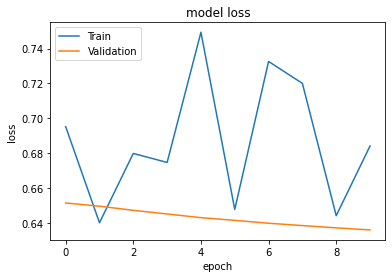

In [171]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [174]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_25_clstr_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_25_full_clstr_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_25_clstr_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_25_clstr_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 13, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 13, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 13, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_clstr_v2.ckpt/assets


5/5 [==============================] - 2s 258ms/step - loss: 0.9573 - sparse_categorical_accuracy: 0.3289 - val_loss: 0.8982 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 1.0641 - sparse_categorical_accuracy: 0.2500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_25_full_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 233ms/step - loss: 0.9895 - sparse_categorical_accuracy: 0.3947 - val_loss: 0.8871 - val_sparse_categorical_accuracy: 0.4000
Epoch 3/10
5/5 [==============================] - 0s 11ms/step - loss: 0.9721 - sparse_categorical_accuracy: 0.3553 - val_loss: 0.8769 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/10
5/5 [==============================] - 0s 9ms/step - loss: 0.9876 - sparse_categorical_accuracy: 0.3421 - val_loss: 0.8666 - val_sparse_categorical_accuracy: 0.4000
Epoch 5/10
5/5 [==============================] - 0s 10ms/step - loss: 0.9812 - sparse_categorical_accuracy: 0.3158 - val_loss: 0.8567 - val_sparse_categorical_accuracy: 0.4000
Epoch 6/10
5/5 [==============================] - 0s 11ms/step - loss: 0.8887 - sparse_categorical_accuracy: 0.3816 - val_loss: 0.8473 - val_sparse_categorical_accuracy: 0.4000
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 0.9742 - sparse_categorical_accuracy: 0.3553 - val_loss

[0.8082615733146667, 0.3333333432674408]

Test Set Prediction Accuracy: 0.3333
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


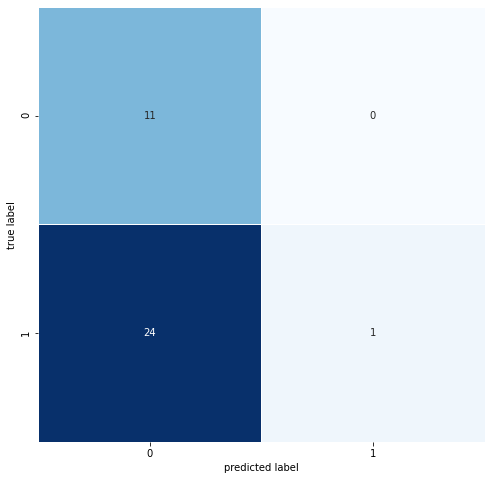

In [175]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_25_clstr_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

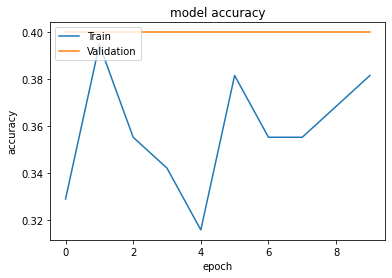

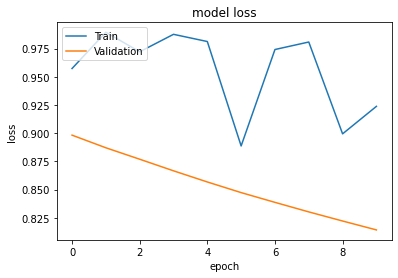

In [176]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [177]:
# Read in the train data for all of the 'thresh 5' datasets
X_train_pct_50_full = pd.read_pickle('X_train_pct_50_full')
X_train_pct_50_full_v2 = pd.read_pickle('X_train_pct_50_full_v2')
X_test_pct_50_full = pd.read_pickle('X_test_pct_50_full')
X_test_pct_50_full_v2 = pd.read_pickle('X_test_pct_50_full_v2')

X_train_pct_50 = pd.read_pickle('X_train_pct_50')
X_train_pct_50_v2 = pd.read_pickle('X_train_pct_50_v2')
X_test_pct_50 = pd.read_pickle('X_test_pct_50')
X_test_pct_50_v2 = pd.read_pickle('X_test_pct_50_v2')

X_train_pct_50_clstr = pd.read_pickle('X_train_pct_50_clstr')
X_train_pct_50_clstr_v2 = pd.read_pickle('X_train_pct_50_clstr_v2')
X_test_pct_50_clstr = pd.read_pickle('X_test_pct_50_clstr')
X_test_pct_50_clstr_v2 = pd.read_pickle('X_test_pct_50_clstr_v2')

In [178]:
# Send the data to np arrays
X_train_pct_50_full = X_train_pct_50_full.to_numpy()
X_test_pct_50_full = X_test_pct_50_full.to_numpy()
X_train_pct_50_full_v2 = X_train_pct_50_full_v2.to_numpy()
X_test_pct_50_full_v2 = X_test_pct_50_full_v2.to_numpy()

X_train_pct_50 = X_train_pct_50.to_numpy()
X_test_pct_50 = X_test_pct_50.to_numpy()
X_train_pct_50_v2 = X_train_pct_50_v2.to_numpy()
X_test_pct_50_v2 = X_test_pct_50_v2.to_numpy()

X_train_pct_50_clstr = X_train_pct_50_clstr.to_numpy()
X_test_pct_50_clstr = X_test_pct_50_clstr.to_numpy()
X_train_pct_50_clstr_v2 = X_train_pct_50_clstr_v2.to_numpy()
X_test_pct_50_clstr_v2 = X_test_pct_50_clstr_v2.to_numpy()

# Reshape the datasets to the requirements of the transformer-based Keras architecture
X_train_pct_50_full = X_train_pct_50_full.reshape((X_train_pct_50_full.shape[0], X_train_pct_50_full.shape[1], 1))
X_test_pct_50_full = X_test_pct_50_full.reshape((X_test_pct_50_full.shape[0], X_test_pct_50_full.shape[1], 1))
X_train_pct_50_full_v2 = X_train_pct_50_full_v2.reshape((X_train_pct_50_full_v2.shape[0], X_train_pct_50_full_v2.shape[1], 1))
X_test_pct_50_full_v2 = X_test_pct_50_full_v2.reshape((X_test_pct_50_full_v2.shape[0], X_test_pct_50_full_v2.shape[1], 1))

X_train_pct_50 = X_train_pct_50.reshape((X_train_pct_50.shape[0], X_train_pct_50.shape[1], 1))
X_test_pct_50 = X_test_pct_50.reshape((X_test_pct_50.shape[0], X_test_pct_50.shape[1], 1))
X_train_pct_50_v2 = X_train_pct_50_v2.reshape((X_train_pct_50_v2.shape[0], X_train_pct_50_v2.shape[1], 1))
X_test_pct_50_v2 = X_test_pct_50_v2.reshape((X_test_pct_50_v2.shape[0], X_test_pct_50_v2.shape[1], 1))

X_train_pct_50_clstr = X_train_pct_50_clstr.reshape((X_train_pct_50_clstr.shape[0], X_train_pct_50_clstr.shape[1], 1))
X_test_pct_50_clstr = X_test_pct_50_clstr.reshape((X_test_pct_50_clstr.shape[0], X_test_pct_50_clstr.shape[1], 1))
X_train_pct_50_clstr_v2 = X_train_pct_50_clstr_v2.reshape((X_train_pct_50_clstr_v2.shape[0], X_train_pct_50_clstr_v2.shape[1], 1))
X_test_pct_50_clstr_v2 = X_test_pct_50_clstr_v2.reshape((X_test_pct_50_clstr_v2.shape[0], X_test_pct_50_clstr_v2.shape[1], 1))



In [179]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_50_full.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_50_full.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_50_full,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_50_full, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


6/6 [==============================] - 2s 208ms/step - loss: 0.8028 - sparse_categorical_accuracy: 0.3837 - val_loss: 0.6925 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7160 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


6/6 [==============================] - 1s 187ms/step - loss: 0.7333 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.6836 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7661 - sparse_categorical_accuracy: 0.5465 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.5455
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 0.7321 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.5349 - val_loss: 0.6609 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6135 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


6/6 [==============================] - 1s 191ms/step - loss: 0.6929 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.6548 - val_sparse_categorical_accuracy: 0.5455
Epoch 7/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7646 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


6/6 [==============================] - 1s 245ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.6047 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.5455
Epoch 8/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6037 - sparse_categorical_accuracy: 0.7500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full.ckpt/assets


6/6 [==============================] - 1s 189ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.6453 - val_sparse_categorical_accuracy: 0.5909
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6974 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.6414 - val_sparse_categorical_accuracy: 0.5909
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 0.7130 - sparse_categorical_accuracy: 0.6250


[0.713019609451294, 0.625]

Test Set Prediction Accuracy: 0.625
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


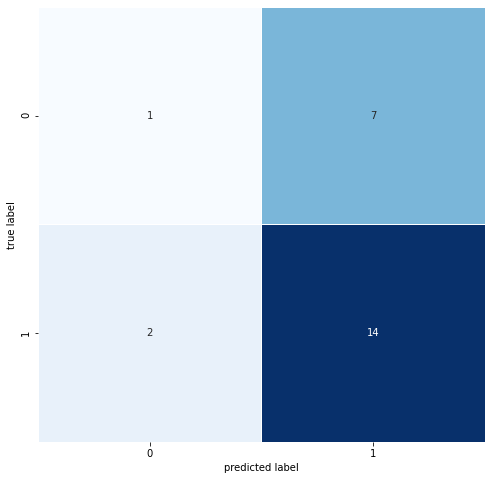

In [180]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_50_full)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

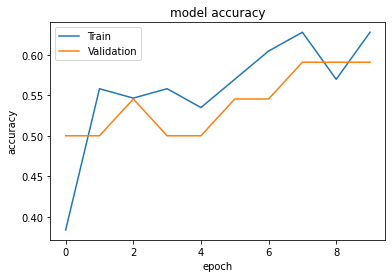

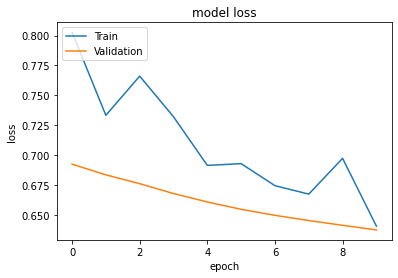

In [181]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [185]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_50_full_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_50_full_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_50_full_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_50_full_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full_v2.ckpt/assets


5/5 [==============================] - 2s 259ms/step - loss: 0.7546 - sparse_categorical_accuracy: 0.5132 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7755 - sparse_categorical_accuracy: 0.4605 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7538 - sparse_categorical_accuracy: 0.4474 - val_loss: 0.6390 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7709 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.7107 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.6348 - val_sparse_categorical_accuracy: 0.4500
Epoch 5/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7334 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6307 - val_sparse_categorical_accuracy: 0.5500
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7097 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6272 - val_sparse_categorical_accuracy: 0.6500
Epoch 7/10
5/5 [==============================] - 0s 9ms/step - loss: 0.7019 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.6500
Epoch 8/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6843 - sparse_categorical_accuracy: 0.5658 - val_loss: 0.6215 - val_sparse_categorical_accuracy: 0.6500
Epoch 9/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7027 - sparse_categorical_accuracy: 0.5395 - val_loss

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_full_v2.ckpt/assets


2/2 [==============================] - 0s 3ms/step - loss: 0.7308 - sparse_categorical_accuracy: 0.4722


[0.7307987213134766, 0.4722222089767456]

Test Set Prediction Accuracy: 0.4722
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


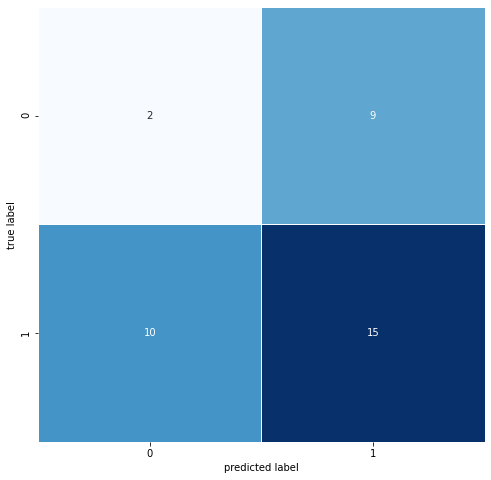

In [186]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_50_full_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

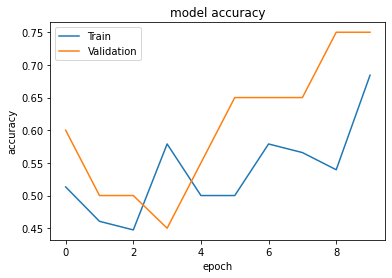

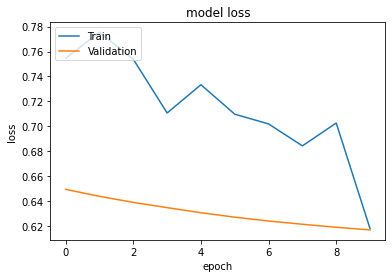

In [187]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [188]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_50.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_50.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_50,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_50, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 6, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


6/6 [==============================] - 2s 205ms/step - loss: 0.7130 - sparse_categorical_accuracy: 0.5233 - val_loss: 0.6706 - val_sparse_categorical_accuracy: 0.5909
Epoch 2/10
6/6 [==============================] - 0s 8ms/step - loss: 0.7168 - sparse_categorical_accuracy: 0.4884 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.6364
Epoch 3/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7421 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


6/6 [==============================] - 1s 188ms/step - loss: 0.6781 - sparse_categorical_accuracy: 0.5465 - val_loss: 0.6640 - val_sparse_categorical_accuracy: 0.6364
Epoch 4/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6681 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


6/6 [==============================] - 1s 254ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.5909
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6660 - sparse_categorical_accuracy: 0.5349 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.6364
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6754 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.6364
Epoch 7/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6660 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6531 - val_sparse_categorical_accuracy: 0.6364
Epoch 8/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7904 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


6/6 [==============================] - 1s 189ms/step - loss: 0.6790 - sparse_categorical_accuracy: 0.5930 - val_loss: 0.6511 - val_sparse_categorical_accuracy: 0.6364
Epoch 9/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7196 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50.ckpt/assets


6/6 [==============================] - 1s 191ms/step - loss: 0.6800 - sparse_categorical_accuracy: 0.6047 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6364
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.7083


[0.6224539279937744, 0.7083333134651184]

Test Set Prediction Accuracy: 0.7083
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


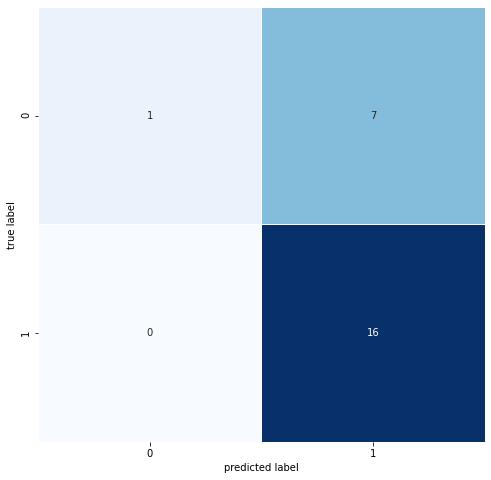

In [189]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_50)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

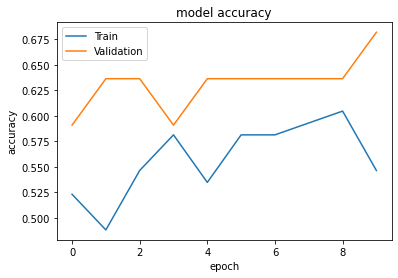

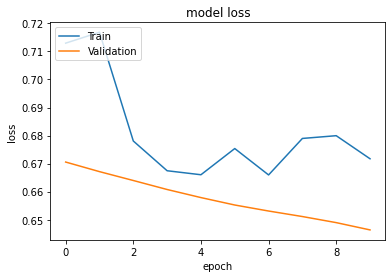

In [190]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [191]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_50_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_50_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_50_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_50_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 6, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_v2.ckpt/assets


5/5 [==============================] - 2s 340ms/step - loss: 0.6236 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.6316 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.6614 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 0s 2ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.6667


[0.644364595413208, 0.6666666865348816]

Test Set Prediction Accuracy: 0.6667
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


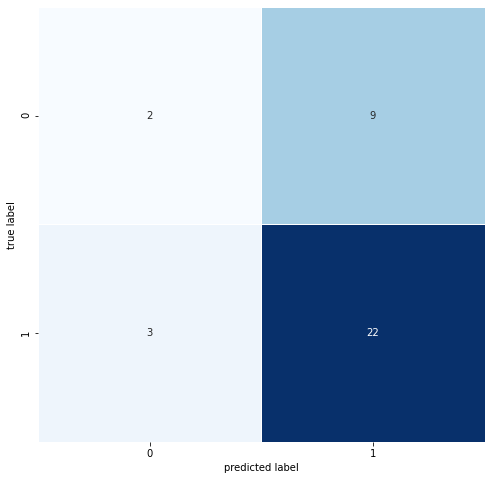

In [192]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_50_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

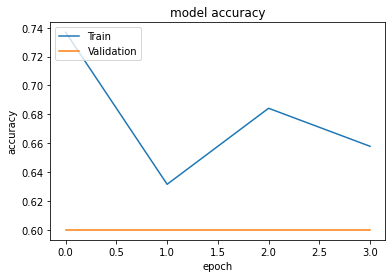

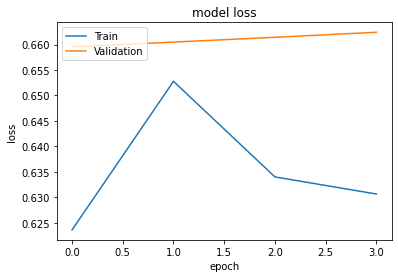

In [193]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [195]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_50_clstr.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_50_clstr.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_50_clstr,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_50_clstr, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr.ckpt/assets


6/6 [==============================] - 2s 208ms/step - loss: 0.8511 - sparse_categorical_accuracy: 0.4535 - val_loss: 0.6817 - val_sparse_categorical_accuracy: 0.5455
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7938 - sparse_categorical_accuracy: 0.4419 - val_loss: 0.6730 - val_sparse_categorical_accuracy: 0.6364
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.8071 - sparse_categorical_accuracy: 0.4186 - val_loss: 0.6641 - val_sparse_categorical_accuracy: 0.6364
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.8112 - sparse_categorical_accuracy: 0.4186 - val_loss: 0.6555 - val_sparse_categorical_accuracy: 0.6364
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.8792 - sparse_categorical_accuracy: 0.3488 - val_loss: 0.6478 - val_sparse_categorical_accuracy: 0.6364
Epoch 6/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7661 - sparse_categorical_accuracy: 0.3750INFO:tensorflow:Ass

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr.ckpt/assets


6/6 [==============================] - 1s 259ms/step - loss: 0.7712 - sparse_categorical_accuracy: 0.4767 - val_loss: 0.6405 - val_sparse_categorical_accuracy: 0.6364
Epoch 7/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7637 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr.ckpt/assets


6/6 [==============================] - 1s 191ms/step - loss: 0.7335 - sparse_categorical_accuracy: 0.5116 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.5909
Epoch 8/10
6/6 [==============================] - 0s 9ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.5116 - val_loss: 0.6282 - val_sparse_categorical_accuracy: 0.5909
Epoch 9/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6669 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr.ckpt/assets


6/6 [==============================] - 1s 189ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.6364
Epoch 10/10
1/1 [==============================] - 0s 16ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.5833


[0.6495925188064575, 0.5833333134651184]

Test Set Prediction Accuracy: 0.5833
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


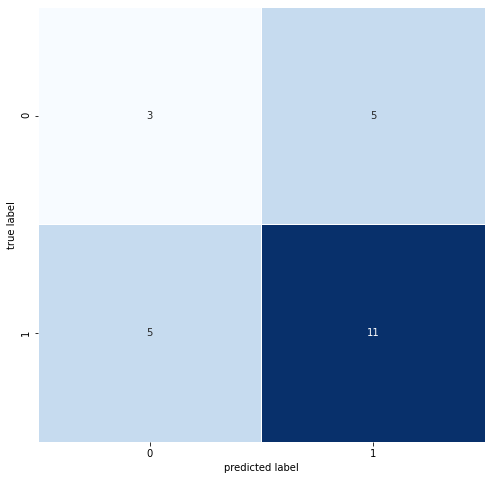

In [196]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_50_clstr)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

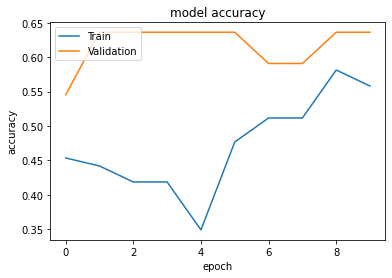

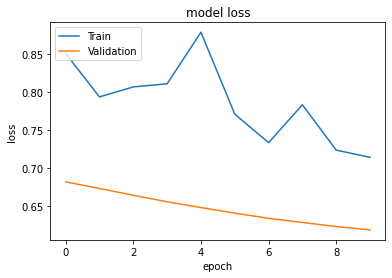

In [197]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [198]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_50_clstr_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_50_clstr_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_50_clstr_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


5/5 [==============================] - 2s 336ms/step - loss: 0.7589 - sparse_categorical_accuracy: 0.5526 - val_loss: 0.6443 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.8261 - sparse_categorical_accuracy: 0.5132 - val_loss: 0.6435 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/10
5/5 [==============================] - 0s 11ms/step - loss: 0.7846 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6433 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7855 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 240ms/step - loss: 0.7789 - sparse_categorical_accuracy: 0.5658 - val_loss: 0.6433 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/10
1/5 [=====>........................] - ETA: 0s - loss: 0.7049 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 237ms/step - loss: 0.7163 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.6437 - val_sparse_categorical_accuracy: 0.6500
Epoch 6/10
5/5 [==============================] - 0s 9ms/step - loss: 0.7946 - sparse_categorical_accuracy: 0.5526 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.6000
Epoch 7/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6302 - sparse_categorical_accuracy: 0.6875INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_50_clstr_v2.ckpt/assets


2/2 [==============================] - 0s 3ms/step - loss: 0.7265 - sparse_categorical_accuracy: 0.5000


[0.7264961004257202, 0.5]

Test Set Prediction Accuracy: 0.5
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


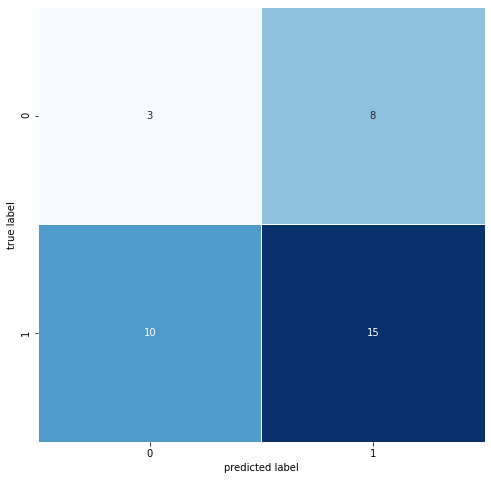

In [199]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_50_clstr_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

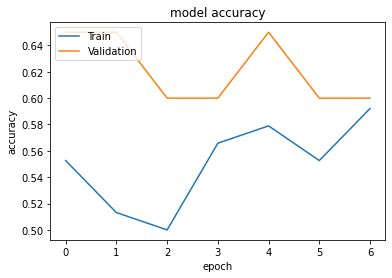

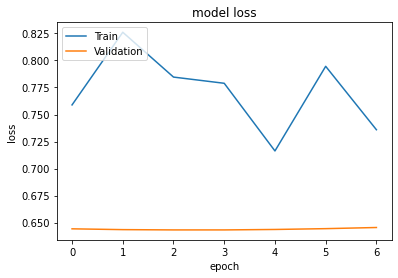

In [200]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [201]:
# Read in the train data for all of the 'thresh 5' datasets
X_train_pct_75_full = pd.read_pickle('X_train_pct_75_full')
X_train_pct_75_full_v2 = pd.read_pickle('X_train_pct_75_full_v2')
X_test_pct_75_full = pd.read_pickle('X_test_pct_75_full')
X_test_pct_75_full_v2 = pd.read_pickle('X_test_pct_75_full_v2')

X_train_pct_75 = pd.read_pickle('X_train_pct_75')
X_train_pct_75_v2 = pd.read_pickle('X_train_pct_75_v2')
X_test_pct_75 = pd.read_pickle('X_test_pct_75')
X_test_pct_75_v2 = pd.read_pickle('X_test_pct_75_v2')

X_train_pct_75_clstr = pd.read_pickle('X_train_pct_75_clstr')
X_train_pct_75_clstr_v2 = pd.read_pickle('X_train_pct_75_clstr_v2')
X_test_pct_75_clstr = pd.read_pickle('X_test_pct_75_clstr')
X_test_pct_75_clstr_v2 = pd.read_pickle('X_test_pct_75_clstr_v2')

In [202]:
# Send the data to np arrays
X_train_pct_75_full = X_train_pct_75_full.to_numpy()
X_test_pct_75_full = X_test_pct_75_full.to_numpy()
X_train_pct_75_full_v2 = X_train_pct_75_full_v2.to_numpy()
X_test_pct_75_full_v2 = X_test_pct_75_full_v2.to_numpy()

X_train_pct_75 = X_train_pct_75.to_numpy()
X_test_pct_75 = X_test_pct_75.to_numpy()
X_train_pct_75_v2 = X_train_pct_75_v2.to_numpy()
X_test_pct_75_v2 = X_test_pct_75_v2.to_numpy()

X_train_pct_75_clstr = X_train_pct_75_clstr.to_numpy()
X_test_pct_75_clstr = X_test_pct_75_clstr.to_numpy()
X_train_pct_75_clstr_v2 = X_train_pct_75_clstr_v2.to_numpy()
X_test_pct_75_clstr_v2 = X_test_pct_75_clstr_v2.to_numpy()

# Reshape the datasets to the requirements of the transformer-based Keras architecture
X_train_pct_75_full = X_train_pct_75_full.reshape((X_train_pct_75_full.shape[0], X_train_pct_75_full.shape[1], 1))
X_test_pct_75_full = X_test_pct_75_full.reshape((X_test_pct_75_full.shape[0], X_test_pct_75_full.shape[1], 1))
X_train_pct_75_full_v2 = X_train_pct_75_full_v2.reshape((X_train_pct_75_full_v2.shape[0], X_train_pct_75_full_v2.shape[1], 1))
X_test_pct_75_full_v2 = X_test_pct_75_full_v2.reshape((X_test_pct_75_full_v2.shape[0], X_test_pct_75_full_v2.shape[1], 1))

X_train_pct_75 = X_train_pct_75.reshape((X_train_pct_75.shape[0], X_train_pct_75.shape[1], 1))
X_test_pct_75 = X_test_pct_75.reshape((X_test_pct_75.shape[0], X_test_pct_75.shape[1], 1))
X_train_pct_75_v2 = X_train_pct_75_v2.reshape((X_train_pct_75_v2.shape[0], X_train_pct_75_v2.shape[1], 1))
X_test_pct_75_v2 = X_test_pct_75_v2.reshape((X_test_pct_75_v2.shape[0], X_test_pct_75_v2.shape[1], 1))

X_train_pct_75_clstr = X_train_pct_75_clstr.reshape((X_train_pct_75_clstr.shape[0], X_train_pct_75_clstr.shape[1], 1))
X_test_pct_75_clstr = X_test_pct_75_clstr.reshape((X_test_pct_75_clstr.shape[0], X_test_pct_75_clstr.shape[1], 1))
X_train_pct_75_clstr_v2 = X_train_pct_75_clstr_v2.reshape((X_train_pct_75_clstr_v2.shape[0], X_train_pct_75_clstr_v2.shape[1], 1))
X_test_pct_75_clstr_v2 = X_test_pct_75_clstr_v2.reshape((X_test_pct_75_clstr_v2.shape[0], X_test_pct_75_clstr_v2.shape[1], 1))


In [206]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_75_full.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_75_full.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_75_full,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_75_full, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_full.ckpt/assets


6/6 [==============================] - 2s 207ms/step - loss: 0.7478 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.5687 - val_sparse_categorical_accuracy: 0.7273
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.5648 - sparse_categorical_accuracy: 0.7500INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_full.ckpt/assets


6/6 [==============================] - 1s 252ms/step - loss: 0.7192 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.5689 - val_sparse_categorical_accuracy: 0.7273
Epoch 3/10
1/6 [====>.........................] - ETA: 0s - loss: 0.6875 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_full.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_full.ckpt/assets


6/6 [==============================] - 1s 193ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.5694 - val_sparse_categorical_accuracy: 0.7273
Epoch 4/10
1/1 [==============================] - 0s 16ms/step - loss: 0.6605 - sparse_categorical_accuracy: 0.6667


[0.6604548096656799, 0.6666666865348816]

Test Set Prediction Accuracy: 0.6667
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


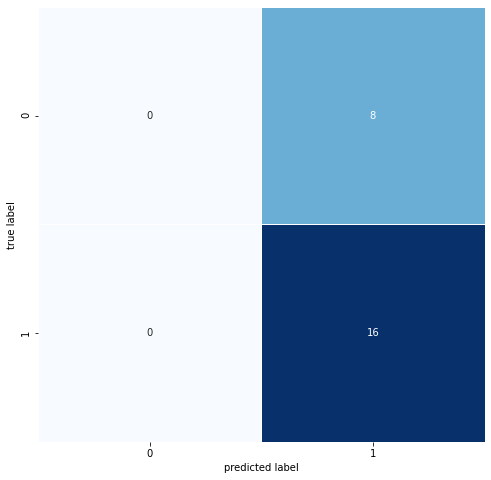

In [207]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_75_full)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

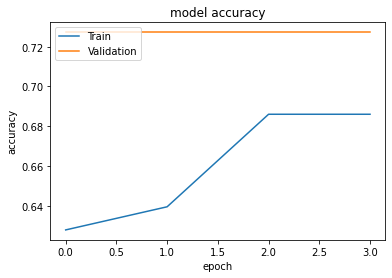

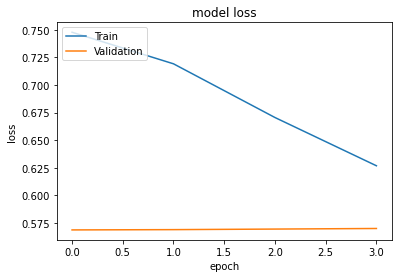

In [208]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [211]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_75_full_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_75_full_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_75_full_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_75_full_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 1)]      0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 20, 1)       449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 20, 1)        0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 20, 1)       2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_full_v2.ckpt/assets


5/5 [==============================] - 2s 257ms/step - loss: 0.6190 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.7041 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.7117 - sparse_categorical_accuracy: 0.6316 - val_loss: 0.7060 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.7074 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.6389


[0.642167866230011, 0.6388888955116272]

Test Set Prediction Accuracy: 0.6389
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


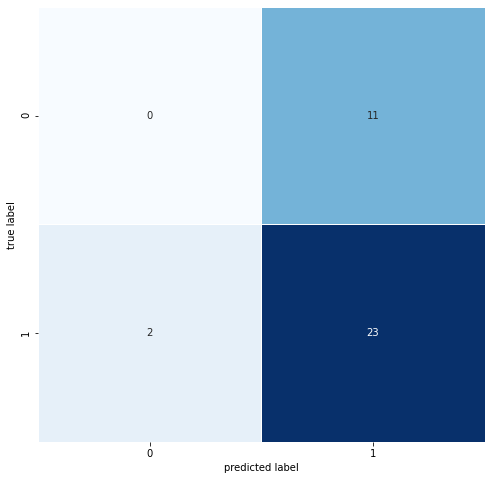

In [212]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_75_full_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

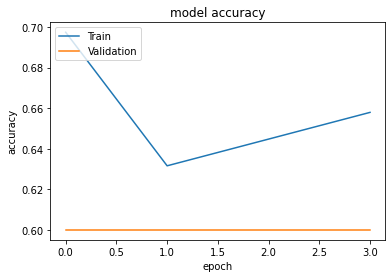

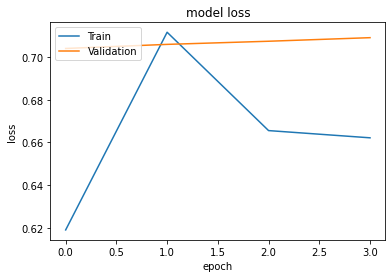

In [213]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [215]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_75.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_75.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_75,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_75, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 8, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75.ckpt/assets


6/6 [==============================] - 2s 276ms/step - loss: 0.6618 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6373 - val_sparse_categorical_accuracy: 0.7273
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.7395 - sparse_categorical_accuracy: 0.5000INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75.ckpt/assets


6/6 [==============================] - 1s 192ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.6346 - val_sparse_categorical_accuracy: 0.7273
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6713 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.6325 - val_sparse_categorical_accuracy: 0.7273
Epoch 4/10
6/6 [==============================] - 0s 10ms/step - loss: 0.7002 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6302 - val_sparse_categorical_accuracy: 0.7273
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.6283 - val_sparse_categorical_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.6267 - val_sparse_categorical_accuracy: 0.7273
Epoch 7/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.6395 - val_loss: 0

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75.ckpt/assets


6/6 [==============================] - 1s 190ms/step - loss: 0.6334 - sparse_categorical_accuracy: 0.6628 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.7273
Epoch 10/10
1/1 [==============================] - 0s 16ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.5833


[0.670887291431427, 0.5833333134651184]

Test Set Prediction Accuracy: 0.5833
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


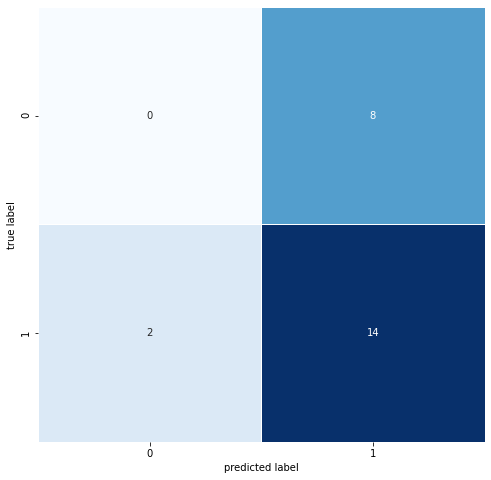

In [216]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_75)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

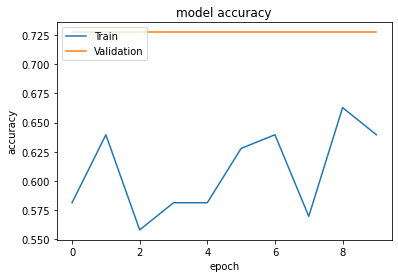

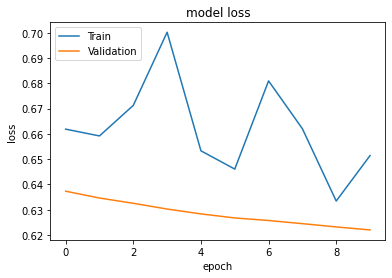

In [217]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [218]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_75_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_75_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_75_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_75_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 8, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_v2.ckpt/assets


5/5 [==============================] - 2s 274ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.5960 - sparse_categorical_accuracy: 0.7105 - val_loss: 0.7143 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.6944


[0.6408436298370361, 0.6944444179534912]

Test Set Prediction Accuracy: 0.6944
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


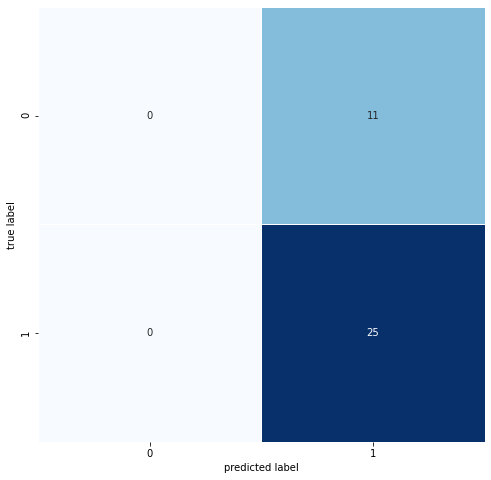

In [219]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_75_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

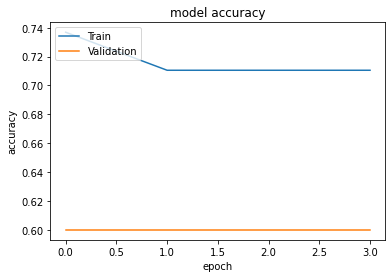

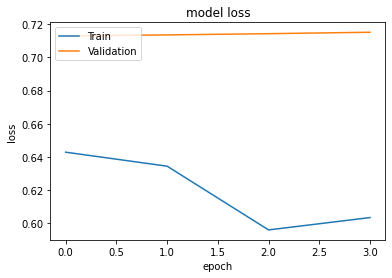

In [220]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [221]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_75_clstr.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_75_clstr.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_75_clstr,
    y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_75_clstr, y_test_nn, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 8, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr.ckpt/assets


6/6 [==============================] - 2s 209ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.5793 - val_sparse_categorical_accuracy: 0.7273
Epoch 2/10
1/6 [====>.........................] - ETA: 0s - loss: 0.5403 - sparse_categorical_accuracy: 0.8125INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr.ckpt/assets


6/6 [==============================] - 1s 187ms/step - loss: 0.6170 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.5784 - val_sparse_categorical_accuracy: 0.7273
Epoch 3/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.5780 - val_sparse_categorical_accuracy: 0.7273
Epoch 4/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.5775 - val_sparse_categorical_accuracy: 0.7273
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.5770 - val_sparse_categorical_accuracy: 0.7273
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.5762 - val_sparse_categorical_accuracy: 0.7273
Epoch 7/10
6/6 [==============================] - 0s 8ms/step - loss: 0.6595 - sparse_categorical_accuracy: 0.6395 - val_loss: 0.

[0.6379157900810242, 0.6666666865348816]

Test Set Prediction Accuracy: 0.6667
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


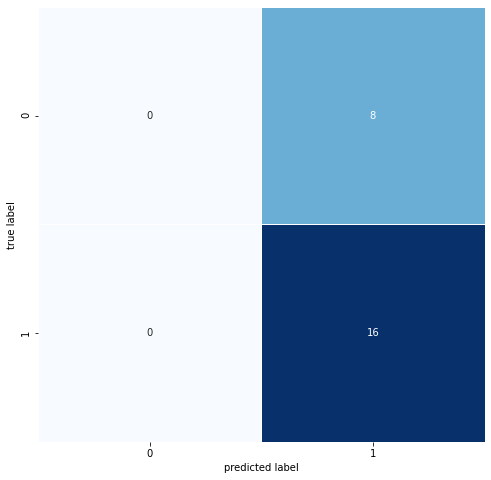

In [222]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_75_clstr)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn, preds)

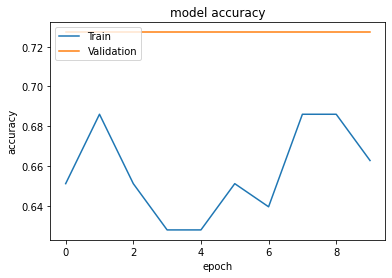

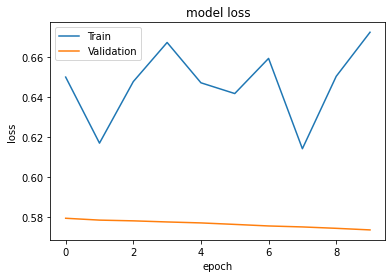

In [223]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [224]:
# Clear any prior session memory before beginning
tensorflow.keras.backend.clear_session()

# Generate object containing the input shape of the training data
input_shape = X_train_pct_75_clstr_v2.shape[1:]

# Use the build model function to specify paramaters and instantiate the model
model = build_model(
    input_shape,
    head_size=64,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[64],
    mlp_dropout=0.5,
    dropout=0.4,
)

# Compile the model just built
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
# Summarize the model configuration
model.summary()

# Set model callbacks
ckpt = model_checkpoint_cb(filename='nn_model_checkpoints/cp_pct_75_clstr_v2.ckpt')
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            ckpt]

# Fit the model
history = model.fit(
    X_train_pct_75_clstr_v2,
    y_train_nn_v2,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[callbacks],
)

# Evaluate model performance on the held-out test set
model.evaluate(X_test_pct_75_clstr_v2, y_test_nn_v2, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 8, 1)        449         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 8, 1)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 8, 1)        2           ['dropout[0][0]']            

INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr_v2.ckpt/assets


5/5 [==============================] - 2s 326ms/step - loss: 0.6315 - sparse_categorical_accuracy: 0.6316 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/10
1/5 [=====>........................] - ETA: 0s - loss: 0.5649 - sparse_categorical_accuracy: 0.6250INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 238ms/step - loss: 0.6191 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.5921 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6500
Epoch 4/10
1/5 [=====>........................] - ETA: 0s - loss: 0.6212 - sparse_categorical_accuracy: 0.5625INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr_v2.ckpt/assets


INFO:tensorflow:Assets written to: nn_model_checkpoints/cp_pct_75_clstr_v2.ckpt/assets


5/5 [==============================] - 1s 235ms/step - loss: 0.6100 - sparse_categorical_accuracy: 0.6974 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.6500
Epoch 5/10
2/2 [==============================] - 0s 2ms/step - loss: 0.5846 - sparse_categorical_accuracy: 0.6944


[0.5846120715141296, 0.6944444179534912]

Test Set Prediction Accuracy: 0.6944
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


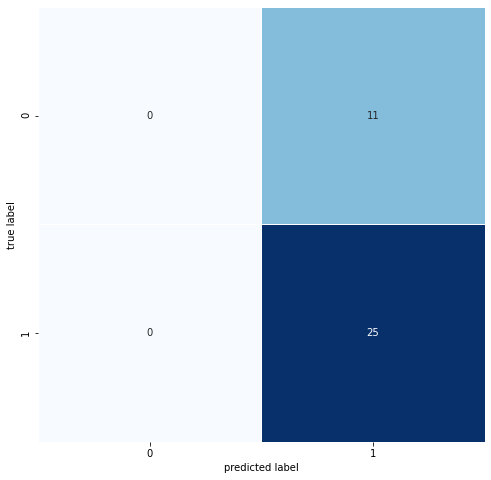

In [226]:
# Save model predictions for the test set to an object and inspect the object
preds = model.predict(X_test_pct_75_clstr_v2)
preds = np.argmax(preds, axis=1)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_nn_v2, preds),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_nn_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_nn_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_nn_v2, preds)

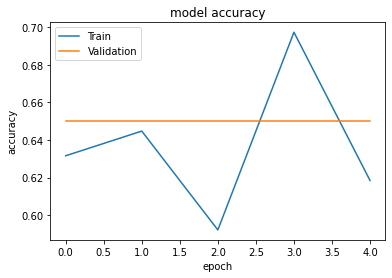

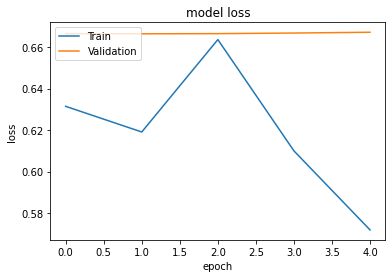

In [227]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


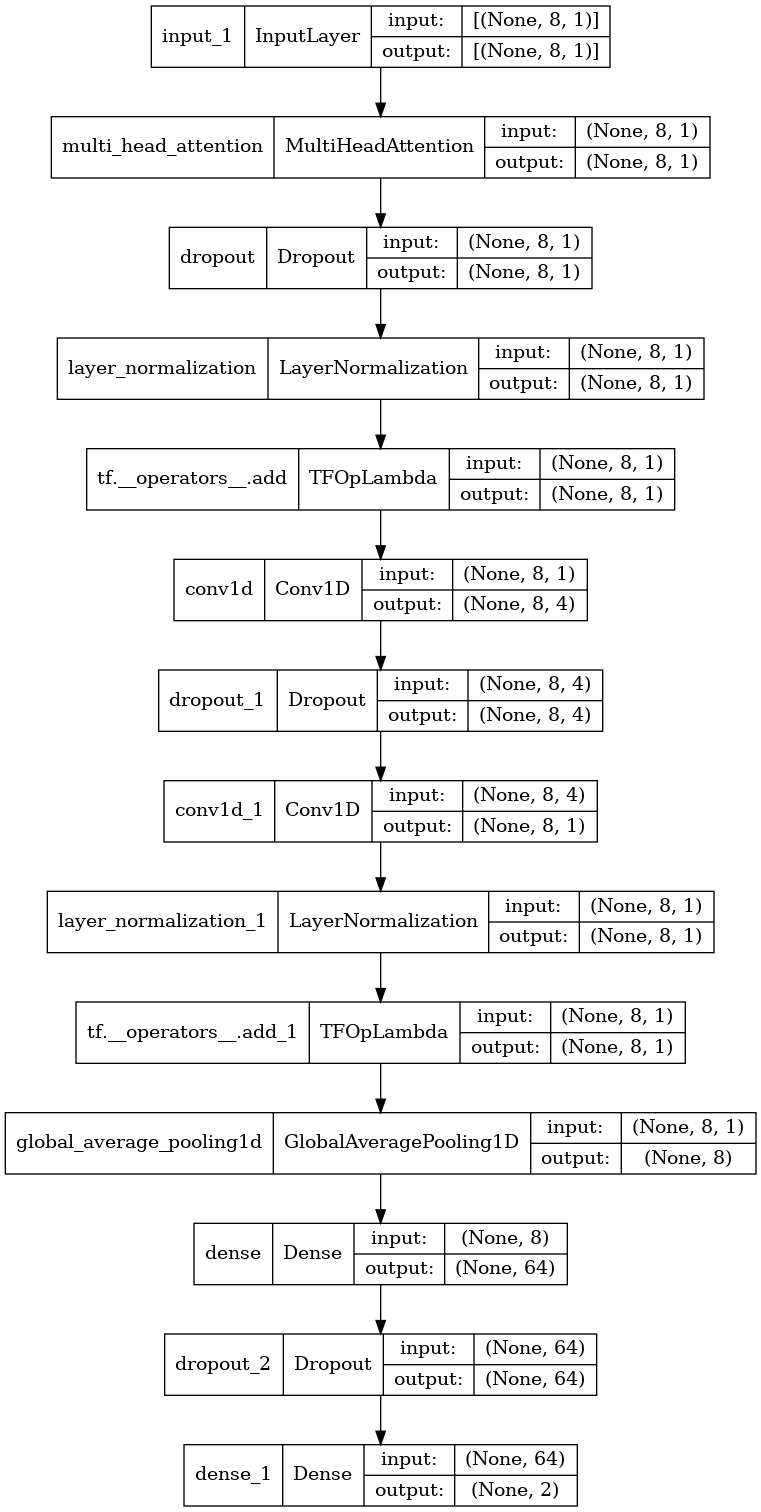

In [229]:
dot_img_file = 'NN_model_1.png'
tensorflow.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)